## Albania isolates with reference genome set

* C. Loiseau et al., “An African origin for Mycobacterium bovis,” Evol. Med. Public Heal., pp. 49–59, 2020.
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647898/

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from snpgenie import tools, aligners, app, trees, plotting

In [28]:
master = pd.read_csv('../mbovis_sra_master.csv')

In [2]:
reload(app)
reload(tools)
args = {'threads':10, 'outdir': '../test_results', 'labelsep':'-',  
        'input':['/storage/btbgenie/mbovis_sra/',
                 '/storage/btbgenie/albania/'],        
        'reference': None, 'overwrite':False,
        'filters' : 'QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35',        
        #'custom_filters': True,
        'buildtree': True,}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

options
-------
threads : 10
outdir : ../test_results
labelsep : -
input : ['/storage/btbgenie/mbovis_sra/', '/storage/btbgenie/albania/']
reference : None
overwrite : False
filters : QUAL>=30 && FORMAT/DP>=30 && DP4>=4 && MQ>35
trim : False
buildtree : True
quality : 25
custom_filters : False
gff_file : None

14 samples were loaded:
----------------------
                   name      sample                                           filename  pair  read_length
0   3_S57_L001-4_R1_001  3_S57_L001  /storage/btbgenie/albania/3_S57_L001-4_R1_001....     1          149
1   3_S57_L001-4_R2_001  3_S57_L001  /storage/btbgenie/albania/3_S57_L001-4_R2_001....     2          149
2    6_S7_L001-4_R1_001   6_S7_L001  /storage/btbgenie/albania/6_S7_L001-4_R1_001.f...     1          150
3    6_S7_L001-4_R2_001   6_S7_L001  /storage/btbgenie/albania/6_S7_L001-4_R2_001.f...     2          150
4           ERR125601_1   ERR125601  /storage/btbgenie/mbovis_sra/ERR125601_1.fastq.gz     1           70
5    

## Create tree labels with meta data

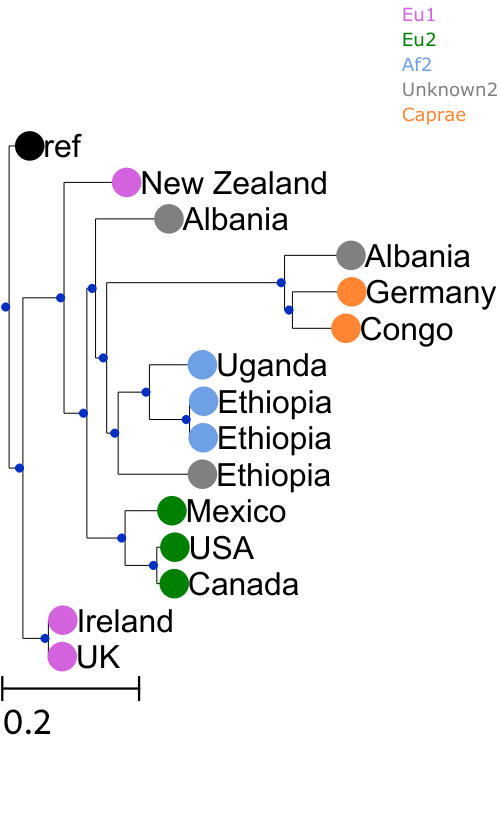

In [43]:
summ = pd.read_csv('../test_results/summary.csv')
#print (summ)
reload(trees)
cols = ['Run','COUNTRY_ISOLATION','CLONAL_COMPLEX','LibraryLayout','Host','ReleaseDate','GENOME_COVERAGE','filename']
df = summ.merge(master,left_on='sample',right_on='Run',how='left').drop_duplicates('bam_file')
df.at[0:1,'COUNTRY_ISOLATION']='Albania'
df.at[0:1,'CLONAL_COMPLEX']='Unknown2'
df.at[3:4,'CLONAL_COMPLEX']='Caprae'
df.at[3,'COUNTRY_ISOLATION']='Congo'
df.at[4,'COUNTRY_ISOLATION']='Germany'
labelmap = dict(zip(df['sample'],df.COUNTRY_ISOLATION))
labelmap
colors = {'Eu1': '#D362DE', 'Eu2': 'Green','Af2':'#6DA0E4','Unknown2':'gray','Caprae':'#ff8533'}
df['color'] = df.CLONAL_COMPLEX.apply(lambda x: colors[x],1)
colormap = dict(zip(df['sample'],df.color))
t,ts = trees.create_tree('../test_results/RAxML_bipartitions.variants', 'ref', labelmap, colormap)
ts.scale_length = .2
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=6),            
            column=0)
        
t.render("%%inline",tree_style=ts,w=500)
#png=t.render('../tree.png',tree_style=ts,dpi=200,w=500)

## AA mutations from csq file

In [59]:
reload(app)
c = app.read_csq_file('../test_results/csq.tsv')
#Caprae mutations
c[c.gene=='gyrB']
#c[c.gene=='lepA']

,1,sample,2,chrom,start,snp_type,gene,locus_tag,strand,feature_type,aa,nuc
43,CSQ,3_S57_L001,1,LT708304.1,6307,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,395A,6307T>G
44,CSQ,3_S57_L001,1,LT708304.1,6406,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,428N,6406T>C
45,CSQ,6_S7_L001,1,LT708304.1,5244,missense,gyrB,BQ2027_MB0005,protein_coding,+,41A>41G,5244C>G
46,CSQ,ERR551023,1,LT708304.1,6307,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,395A,6307T>G
47,CSQ,ERR551023,1,LT708304.1,6406,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,428N,6406T>C
48,CSQ,ERR551704,1,LT708304.1,5880,missense,gyrB,BQ2027_MB0005,protein_coding,+,253T>253I,5880C>T
49,CSQ,ERR551704,1,LT708304.1,6250,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,376L,6250A>G
50,CSQ,ERR551704,1,LT708304.1,6307,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,395A,6307T>G
51,CSQ,ERR551704,1,LT708304.1,6406,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,428N,6406T>C
52,CSQ,SRR8065079,1,LT708304.1,7123,synonymous,gyrB,BQ2027_MB0005,protein_coding,+,667P,7123C>T


In [60]:
snp_mat = app.get_aa_snp_matrix(c)
snp_mat.loc['gyrB',:]

sample,3_S57_L001,6_S7_L001,ERR125601,ERR551023,ERR551704,ERR841808,SRR1791768,SRR1791960,SRR1792002,SRR5216872,SRR5486071,SRR8063654,SRR8063665,SRR8065079
aa,,,,,,,,,,,,,,
253T>253I,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376L,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395A,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41A>41G,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428N,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
reload(tools)

def sequences_from_annotations(files, kind='nucl'):
    """Get specfic sequence from a set of annotation files"""
    
    seqs=[]
    for f in files:
        print (f)
        name = os.path.basename(f)
        df = tools.genbank_to_dataframe(f)
        s = df[df['product']=='DNA gyrase subunit B'].iloc[0]
        #print (s)        
        seqs.append(SeqRecord(Seq(s.sequence),id=name))
    return seqs

files=glob.glob('/storage/btbgenie/pygf_results/*.gbk')
seqs = sequences_from_annotations(files)
SeqIO.write(seqs,'gyrB1.fa','fasta')

## Mutations unique to Caprae

In [64]:
reload(plotting)
caprae_samples = ['3_S57_L001','ERR551023','ERR551704']
#bovis_samples = X/columns
#c[c['sample'].isin(caprae_samples)]
cmut = snp_mat[(snp_mat[caprae_samples].sum(1)==3) & (snp_mat.sum(1)<len(snp_mat.columns)-3)]
#plotting.plot_matrix(cmut[50:80],w=12,h=8)
print (len(cmut), len(snp_mat))

676 3457


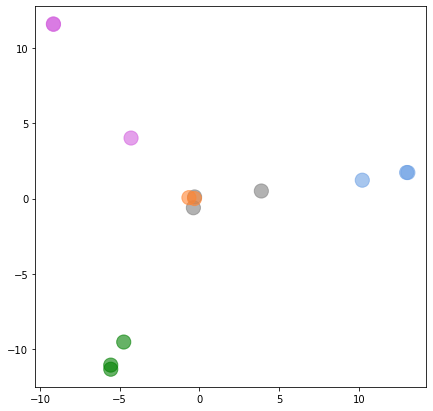

In [70]:
import sklearn
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(snp_mat.T)
X = pca.transform(snp_mat.T)
fig,ax = plt.subplots(figsize=(7, 7))
y = df.color
ax.scatter(X[:, 1], X[:, 2], c=y, s=200, alpha=.6)

## Snippy comparison

https://github.com/tseemann/snippy

In [61]:
#tab file for multi snippy
df = W.fastq_table
x = df.reset_index().pivot(columns='pair', index='sample', values='filename')
x.to_csv('samples.tab',sep='\t')
snippycmd = '/local/snippy/bin/snippy-multi samples.tab --ref Mbovis_AF212297.fa --cpus 10 > runme.sh'

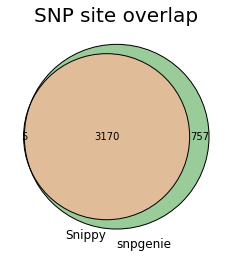

In [71]:
#read snippy snps
snippycore = pd.read_csv('../snippy_run/core.tab',sep='\t')
#print (snippycore[:4])
smat = pd.read_csv('../test_results/core.txt',sep=' ',index_col=0)
print 
import matplotlib_venn
sets=[set(snippycore.POS),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Snippy','snpgenie'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_snippy.png',dpi=100)

In [ ]:
#snippy tree
treefile = trees.run_RAXML('../snippy_run/core.aln', outpath='.')
t,ts = trees.create_tree(treefile, 'Reference', labelmap, colormap)
t.render("%%inline",tree_style=ts,w=500)

## Assemble samples

In [252]:
for i,df in W.fastq_table.groupby('sample'):    
    out=os.path.join('/storage/btbgenie/assembly',i)
    if not os.path.exists(out):
        f1 = df.iloc[0].filename; f2 = df.iloc[1].filename
        cmd = '/local/SPAdes-3.13.0-Linux/bin/spades.py --pe1-1 %s --pe1-2 %s --careful -o %s' %(f1,f2,out)
        print (cmd)
        subprocess.check_output(cmd,shell=True)
    shutil.copy(os.path.join(out,'scaffolds.fasta'), '/storage/btbgenie/scaffolds/%s.fa' %i)

## RD-Analysis

In [ ]:
from snpgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'../rd_aligned')

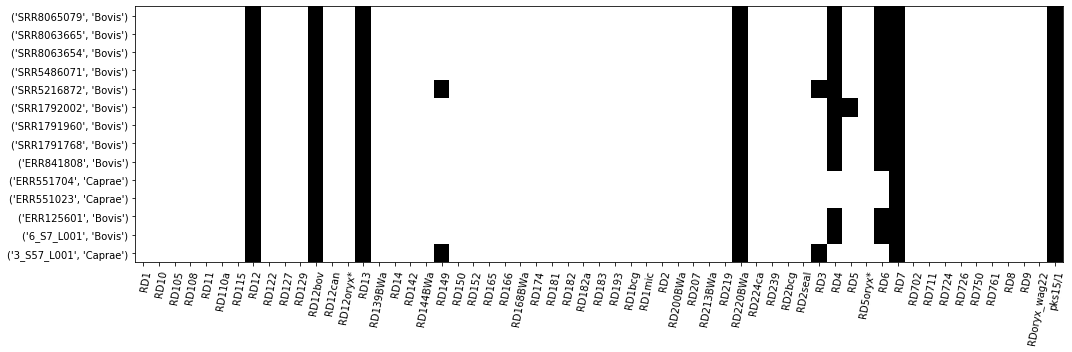

In [20]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
plotting.plot_matrix(X.set_index('ident',append=True), cmap='cubehelix')
plt.savefig('rd_albania.png')

In [ ]:
res[res['#rname']=='RD4']